# The challenge

## 1. Data Science challenge

Participants are required to provide __24 months of volume forecast__ after the generic entry data together with a __95% confidence intervals__ for the given prediction for all the branchs in the test set.

## 2. Business challenge

Provide a __deep exploratory analysis__ on the correlation __between features__ provided and the __impact in the volume sold__ after the generics entry.

# Setup

## Update Libraries

In [ ]:
%pip install pandas==1.2.4
%pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


## Setup Colab

In [ ]:
COLAB = True

if COLAB:
    from google.colab import drive
    # Mount Google Drive
    drive.mount('/gdrive')

    # Move to projects folder
    %cd '/gdrive/MyDrive/Projects' 
    %ls

Mounted at /gdrive
/gdrive/MyDrive/Projects
EntrySignals.ipynb  novartis-datathon-2018/
Interviews/         novartis-datathon-2020/


In [ ]:
GIT_REPOSITORY = "novartis-datathon-2020"

if COLAB:
    # PARENT_DIRECTORY_PATH = "/content"
    # In case you want to clone in your drive:
    PARENT_DIRECTORY_PATH = "/gdrive/MyDrive/Projects"
    PROJECT_PATH = PARENT_DIRECTORY_PATH + "/" + GIT_REPOSITORY
    %cd "{PROJECT_PATH}"

/gdrive/MyDrive/Projects/novartis-datathon-2020


In [ ]:
%ls data

gx_num_generics.csv  gx_therapeutic_area.csv  submission_instructions.pdf
gx_package.csv       gx_volume.csv            submission_template.csv
gx_panel.csv         processed/


# Load data

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")    # or white
sns.set_context("notebook")  # or paper

import scipy.optimize
from pathlib import Path

print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"Python: {sys.version}")

Numpy: 1.19.5
Pandas: 1.2.4
Seaborn: 0.11.1
Python: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


In [ ]:
# Define folder structure
path_data = Path("data")
path_models = Path("models")

# Create folder if does not exist
path_data.mkdir(parents=True, exist_ok=True)
path_models.mkdir(parents=True, exist_ok=True)

%ls

data/  makefile  models/  notebooks/  scripts/  src/  vscode.code-workspace


In [ ]:
def get_counts(s: pd.Series) -> pd.DataFrame:
  c = s.value_counts(dropna=False)
  p = s.value_counts(dropna=False, normalize=True).round(2)
  return pd.concat([c, p], axis=1, keys=['counts', '%'])

## Volume

Historical (pre-generics) volume for __1078 country-brands__ that went generic in the past. Notice that volume can be in different units depending on the country and brand (miligrams, packs, pills, etc)

The data frame is grouped by _country_ and _brand_, that means that each entry represents an specific combination of _country_ and _brand_ over the months observed. Volume is provided at monthly level.

_month_num_ is related to the timing of the data, with respect to the month of the generic entry. That is, when a generic entry to the market `month_num = 0`, when this variable is positive corresponds to a time after the generic entry and viceversa, when is negative is for months prior to the generic. In addition, _month_name_ corresponds to the actual month of the year.

In [ ]:
gx_volume = pd.read_csv(path_data / "gx_volume.csv")
gx_volume.drop("Unnamed: 0", axis=1, inplace=True)
print(gx_volume.shape)
gx_volume.head()

(94954, 5)


,country,brand,volume,month_num,month_name
0,country_1,brand_3,18509088.6,-88,Jul
1,country_1,brand_3,19697508.0,-87,Aug
2,country_1,brand_3,18315721.8,-86,Sep
3,country_1,brand_3,19831199.4,-85,Oct
4,country_1,brand_3,18593281.8,-84,Nov


In [ ]:
index_cols = ["country", "brand"]
print("Number of products (country-brands): {}".format(
    gx_volume.loc[:, index_cols].drop_duplicates().shape[0])
)

print("Number of products with values in (0, 11): {}".format(
    gx_volume.groupby(index_cols).apply(
        lambda x: np.isin(np.arange(0, 12), x.month_num).all()).sum())
)
print("Number of products with values in (0, 23): {}".format(
    gx_volume.groupby(index_cols).apply(
        lambda x: np.isin(np.arange(0, 24), x.month_num).all()).sum())
)

Number of products (country-brands): 1078
Number of products with values in (0, 11): 855
Number of products with values in (0, 23): 768


Some countries only appear one time in the dataset

In [ ]:
# country counts
tmp_ = gx_volume.loc[:, index_cols].drop_duplicates()
tmp_["country"].value_counts()

country_16    190
country_7     169
country_12    146
country_3     134
country_15    125
country_1     113
country_8     102
country_4      84
country_9       3
country_10      3
country_14      2
country_2       2
country_5       2
country_6       1
country_11      1
country_13      1
Name: country, dtype: int64

The same happens with brands, some of them only appear one time

In [ ]:
# brand counts
tmp_["brand"].value_counts()

brand_187    13
brand_477    10
brand_167     9
brand_133     9
brand_352     8
             ..
brand_244     1
brand_361     1
brand_131     1
brand_86      1
brand_183     1
Name: brand, Length: 484, dtype: int64

How many historical data do we have when looking at the overall portfolio? All patents have at least 12 months, then the generics come into the market. As time goes back the number of observations decreases slow down. There is only one product with 137 months with the patent.

This is something to consider when training the model because as much data form the past we use less observation we will have. Does it make sense use the observation -137 if only exist one time? Will the model be able to learn something?

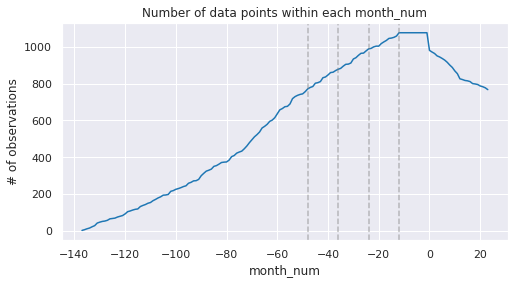

In [ ]:
ax = gx_volume.groupby("month_num").size().plot(figsize=(8, 4))
_ = ax.set_title("Number of data points within each month_num")
_ = ax.set_ylabel("# of observations")
_ = ax.axvline(x=-12, linestyle="--", alpha=0.5, c="grey")
_ = ax.axvline(x=-24, linestyle="--", alpha=0.5, c="grey")
_ = ax.axvline(x=-36, linestyle="--", alpha=0.5, c="grey")
_ = ax.axvline(x=-48, linestyle="--", alpha=0.5, c="grey")

Most generics come in to the market in december.

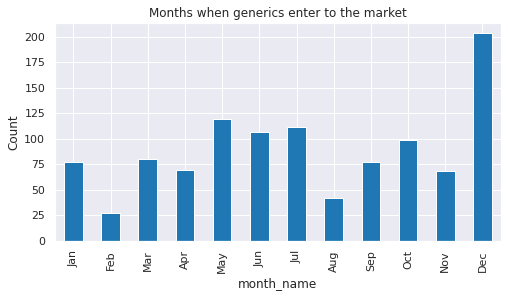

In [ ]:
order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
         "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
tmp_ = gx_volume.query("month_num == -1").groupby("month_name").size().reindex(order)
ax = tmp_.plot(kind="bar", figsize=(8, 4))
_ = ax.set_title("Months when generics enter to the market")
_ = ax.set_ylabel("Count")

## Num generics

For each _country_ and _brand_ the numbers of generics drugs with the same molecule that entry to the market.

In [ ]:
gx_num_generics = pd.read_csv(path_data / "gx_num_generics.csv")
gx_num_generics.drop("Unnamed: 0", axis=1, inplace=True)
print(gx_num_generics.shape)
gx_num_generics.head()

(1078, 3)


,country,brand,num_generics
0,country_1,brand_3,3
1,country_1,brand_4,1
2,country_1,brand_10,6
3,country_1,brand_14,1
4,country_1,brand_18,1


Most of the times will by only few generics that entry to the market. However, in some _brands_ the number of generics is very high, being more than 20.

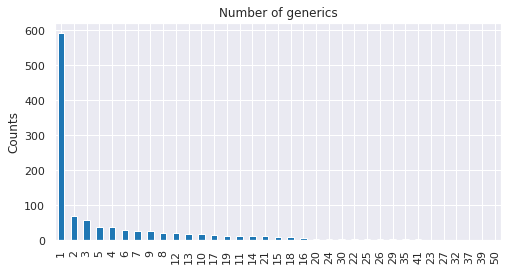

In [ ]:
_ = gx_num_generics["num_generics"].value_counts().plot(
    kind="bar", title="Number of generics", 
    ylabel="Counts", figsize=(8, 4))

## Packaging

This can give us an insight into the presentation of the drug for an specific _country_ and _brand_

In [ ]:
gx_package = pd.read_csv("data/gx_package.csv")
gx_package.drop("Unnamed: 0", axis=1, inplace=True)
print(gx_package.shape)
gx_package.head()

(1078, 3)


,country,brand,presentation
0,country_1,brand_3,PILL
1,country_1,brand_4,PILL
2,country_1,brand_10,PILL
3,country_1,brand_14,PILL
4,country_1,brand_18,CREAM


More than the half of the products are PILLS and 22% are OTHER. This two presentations represent the 85% of the products provided.

In [ ]:
get_counts(gx_package["presentation"])

,counts,%
PILL,677,0.63
OTHER,233,0.22
INJECTION,91,0.08
EYE_DROP,34,0.03
CREAM,29,0.03
PATCH,13,0.01
INHALER,1,0.00


## Therapeutic Area

A threapeutic area represents a group of similar diseases or conditions under a generalized headache. For example, cardiovascular relates to heart diseases, dermatology to skin diseases, etc.

In [ ]:
gx_therapeutic_area = pd.read_csv(path_data / "gx_therapeutic_area.csv")
gx_therapeutic_area.drop("Unnamed: 0", axis=1, inplace=True)
print(gx_therapeutic_area.shape)
gx_therapeutic_area.head()

(484, 2)


,brand,therapeutic_area
0,brand_1,Nervous_system
1,brand_2,Respiratory_and_Immuno_inflammatory
2,brand_3,Cardiovascular_Metabolic
3,brand_4,Cardiovascular_Metabolic
4,brand_5,Cardiovascular_Metabolic


In [ ]:
get_counts(gx_therapeutic_area["therapeutic_area"].str.replace("_", " "))

,counts,%
Cardiovascular Metabolic,125,0.26
Nervous system,102,0.21
Anti infectives,40,0.08
Endocrinology and Metabolic Disease,38,0.08
Obstetrics Gynaecology,37,0.08
Antineoplastic and immunology,37,0.08
Respiratory and Immuno inflammatory,25,0.05
Muscoskeletal Rheumatology and Osteology,22,0.05
Sensory organs,19,0.04
Dermatology,16,0.03


## Panel

This dataset contains the channels of distribution, that is the channels throught the drug is sold. For instance, drugs can be distributed by hospitals, retails, etc. For each _country_ and _brand_ the distribution rate is provided and add to 100.

In [ ]:
gx_panel = pd.read_csv(path_data / "gx_panel.csv")
gx_panel.drop("Unnamed: 0", axis=1, inplace=True)
print(gx_panel.shape)
gx_panel.head()

(2371, 4)


,country,brand,channel,channel_rate
0,country_1,brand_3,B,1.189704
1,country_1,brand_3,D,98.810296
2,country_1,brand_4,B,0.090229
3,country_1,brand_4,D,99.909771
4,country_1,brand_10,B,1.015697


Convert to wide format

In [ ]:
gx_panel_w = (
    gx_panel
    .pivot_table(values="channel_rate", index=index_cols, 
                 columns="channel", fill_value=0)
)
gx_panel_w = gx_panel_w.add_prefix("channel_rate_")
gx_panel_w.reset_index(inplace=True)
gx_panel_w.head()

channel,country,brand,channel_rate_A,channel_rate_B,channel_rate_C,channel_rate_D
0,country_1,brand_10,0,1.015697,0.0,98.984303
1,country_1,brand_102,0,0.109766,0.0,99.890234
2,country_1,brand_115,0,1.992728,0.0,98.007272
3,country_1,brand_117,0,2.148476,0.0,97.851524
4,country_1,brand_119,0,0.605483,0.0,99.394517


In [ ]:
# One hot encoding using pandas `get_dummies`
# cols = ["country", "brand", "channel"]
# gx_panel_w  = pd.get_dummies(gx_panel[cols], columns=["channel"], prefix="channel_rate")
# gx_panel_w = gx_panel_w.groupby(["country", "brand"], as_index=False).sum()
# gx_panel_w.head()

## Submission template

In [ ]:
submission_template = pd.read_csv(path_data / "submission_template.csv")
print(submission_template.shape)
submission_template.head()

(4584, 6)


,country,brand,month_num,pred_95_low,prediction,pred_95_high
0,country_1,brand_121,0,NaN,NaN,NaN
1,country_1,brand_121,1,NaN,NaN,NaN
2,country_1,brand_121,2,NaN,NaN,NaN
3,country_1,brand_121,3,NaN,NaN,NaN
4,country_1,brand_121,4,NaN,NaN,NaN


In [ ]:
print("We must provide forescast for {} products".format(
    submission_template.loc[:, index_cols].drop_duplicates().shape[0])
)

We must provide forescast for 191 products


In [ ]:
# Do exist all products of the submission file in the volume?
cols = ["country", "brand"]
vol_ids = gx_volume.loc[:, cols].drop_duplicates()
sub_ids = submission_template.loc[:, cols].drop_duplicates()
sub_ids.merge(vol_ids, how="inner", on=cols).shape

(191, 2)

# Plot volume function

In [ ]:
# https://stackoverflow.com/questions/40566413/matplotlib-pyplot-auto-adjust-unit-of-y-axis
# https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html
def format_func(value, tick_number):
    if value >= 1e6:
        return '{:d}M'.format(int(value / 1e6))
    elif value >= 1e3:
        return '{:d}k'.format(int(value / 1e3))
    else:
        return '{:.2f}'.format(value)

In [ ]:
def exponential(x, m, t, b):
    return m * np.exp(-t * x) + b

def fit_exponential(ys):
  # sequence of values
  xs = np.arange(len(ys))
  
  # perform the fit
  p0 = (max(ys), .3, max(ys)) # start with values near those we expect
  params, cv = scipy.optimize.curve_fit(exponential, xs, ys, p0, maxfev = 10_000)
  m, t, b = params
  return params

def add_exp_decay(ys, ax=None):
  # Fit exponential curve and find the params
  m, t, b = fit_exponential(ys)

  # extrapolate to all points
  xs2 = np.arange(24)
  ys2 = exponential(xs2, m, t, b)

  # plot the results
  if ax is None:
    f, ax = plt.subplots(1, 1, figsize=(8, 5))
  
  # plot the fitted curve
  _ = ax.plot(xs2, ys2, '--', label="fitted")
  
  # prepare text formula
  text = f"y = {format_func(m, None)}$e^{{-{t:.2f}x}}$ + {format_func(b, None)}"
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
  
  # place a text box in upper left in axes coords
  _ = ax.text(0.02, 0.95, text, fontsize=11, 
              transform=ax.transAxes, ha='left', 
              verticalalignment='top', bbox=props)

  return ax

def add_predictions(
    this_predictions: pd.DataFrame, 
    ax: plt.Axes = None
  ) -> plt.Axes:
  # TODO: Confidence intervals
  ax = ax.plot(this_predictions["month_num"], this_predictions["y_pred"])
  return ax

def plot_volume(
    cc: str = "country_1", 
    bb: str = "brand_3", 
    y_col: str = "volume", 
    predictions: pd.DataFrame = None, 
    add_decay: bool = False,
    ax: plt.Axes = None,
  ) -> plt.Axes:

  # Subset data
  plot_data = gx_volume.query("country == @@cc and brand == @bb")

  # Time series plot
  if ax is None:
    f, ax = plt.subplots(1, 1, figsize=(8, 5))

  ax = sns.lineplot(x="month_num", y=y_col, data=plot_data, ax=ax)
  _ = ax.axvline(x=0, ymin=0, ymax=1, ls="-", lw=4, c="k", alpha=.1)
  _ = ax.set_title(", ".join([cc, bb]))
  _ = ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

  # Color, Alpha and Size
  c, a, s = "brown", 0.8, 10

  # Add extra information
  value = gx_num_generics.query("country == @cc & brand == @bb")["num_generics"].values[0]
  _ = ax.scatter([], [], c=c, alpha=a, s=s, label=f"Num generics: {value}")

  value = gx_therapeutic_area.query("brand == @bb")["therapeutic_area"].values[0]
  _ = ax.scatter([], [], c=c, alpha=a, s=s, label=value)

  value = gx_package.query("country == @cc & brand == @bb")["presentation"].values[0]
  _ = ax.scatter([], [], c=c, alpha=a, s=s, label=f"Presentation: {value}")

  # Show legend
  _ = ax.legend(scatterpoints=1, frameon=True, loc='lower left', 
                fontsize="small", handletextpad=0)
  
  # Add predictions to the plot
  if predictions is not None:
    this_predictions = predictions.query("country == @@cc and brand == @bb")
    _ = add_predictions(this_predictions, ax=ax)
  
  if add_decay:
    _ = add_exp_decay(ys=plot_data.query("month_num >= 0")[y_col].values, ax=ax)

  return ax

## Model results

[Stacking subplots in two directions](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html)

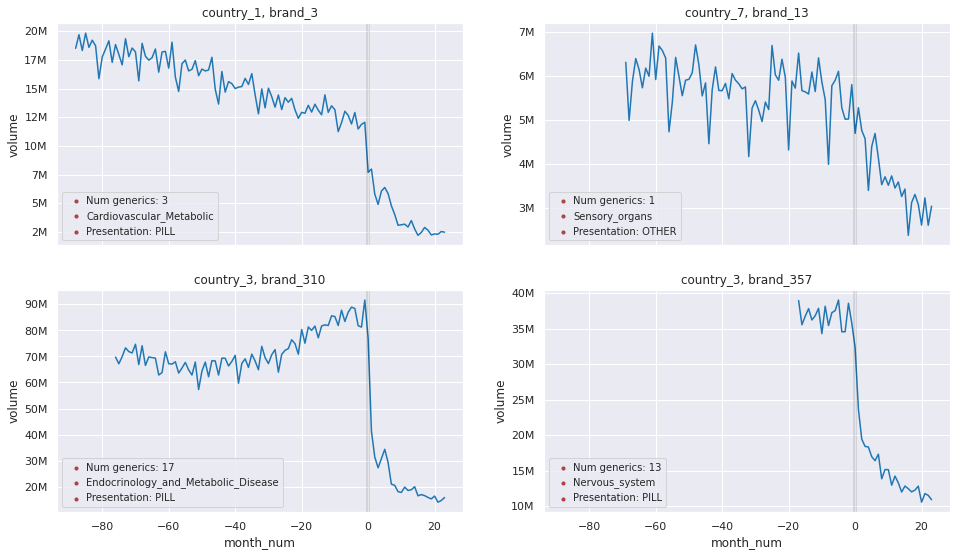

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 9), sharex=True)
products = [
  ("country_1", "brand_3"), ("country_7", "brand_13"), 
  ("country_3", "brand_310"), ("country_3", "brand_357")
]
for p, ax in zip(products, fig.get_axes()):
    _  = plot_volume(cc=p[0], bb=p[1], y_col="volume", ax=ax)

## Anomalies

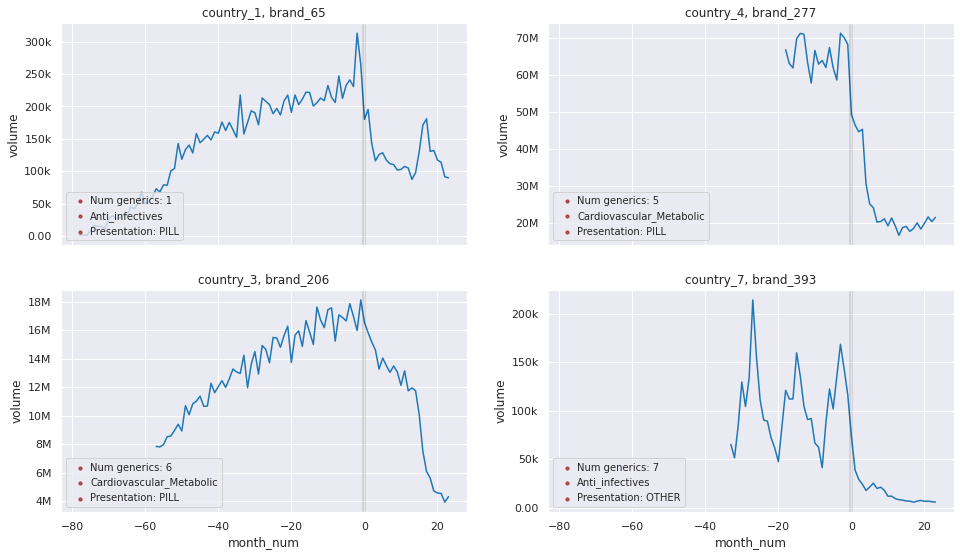

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 9), sharex=True)
products = [
  ("country_1", "brand_65"), ("country_4", "brand_277"), 
  ("country_3", "brand_206"), ("country_7", "brand_393")
]
for p, ax in zip(products, fig.get_axes()):
    _  = plot_volume(cc=p[0], bb=p[1], y_col="volume", ax=ax)

## Exponential decay

When a generic enter to the market hit 

https://stackoverflow.com/questions/15831763/scipy-curvefit-runtimeerroroptimal-parameters-not-found-number-of-calls-to-fun

https://swharden.com/blog/2020-09-24-python-exponential-fit/

http://emilygraceripka.com/blog/14

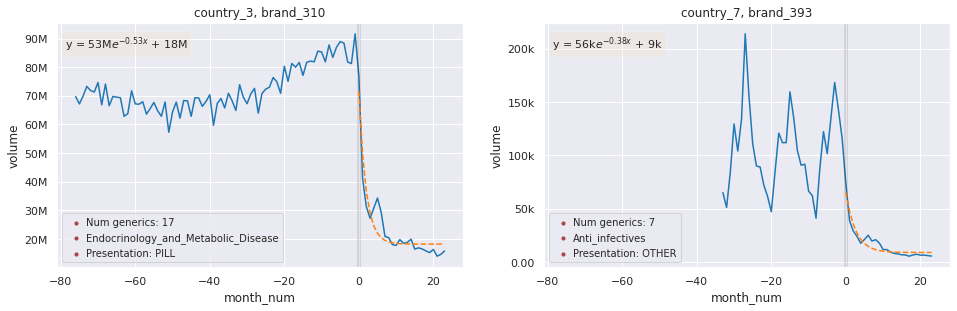

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4.5), sharex=True)
products = [
  ("country_3", "brand_310"), ("country_7", "brand_393")
]
for p, ax in zip(products, fig.get_axes()):
    _  = plot_volume(cc=p[0], bb=p[1], y_col="volume", add_decay=True, ax=ax)

In [ ]:
# products with 24 months of decay
c = gx_volume.query("month_num >= 0").groupby(index_cols).size()
c = c[c == 24].to_frame("n").drop("n", axis=1)

exp_decay_params = (
    gx_volume
    .query("month_num >= 0")
    .merge(c, on=index_cols, how="inner")
    .groupby(index_cols)["volume"]
    .apply(lambda x: fit_exponential(x)[1] )
    .to_frame(name="t")
    .reset_index()
)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


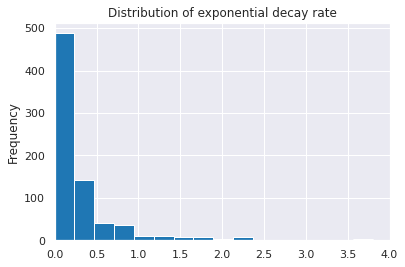

In [ ]:
ax = exp_decay_params["t"].plot(kind="hist", bins=100, xlim=[0, 4])
_ = ax.set_title("Distribution of exponential decay rate")

# Normalize volume

https://stackoverflow.com/questions/55601928/apply-multiple-standardscalers-to-individual-groups

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class VolumeNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.mapping = {}

    def fit(self, X: pd.DataFrame, y=None):
      self.mapping = (
          gx_volume
          .query("month_num == -1")
          .set_index(["country", "brand"])
          .loc[:, "volume"]
          .to_dict()
      )
      return self

    def transform(self, X: pd.DataFrame, 
        new_column: str = "volume_normalized"
      ):
      X = X.set_index(["country", "brand"])
      X[new_column] = X.loc[:, "volume"].divide(
          X.index.map(self.mapping)).values
      return X.reset_index()

    def inverse_transform(self, X: pd.DataFrame, 
        new_column: str = "volume"
      ):
      X = X.set_index(["country", "brand"])
      X[new_column] = X.loc[:, "volume_normalized"].multiply(
          X.index.map(self.mapping)).values
      return X.reset_index()

In [ ]:
scaler = VolumeNormalizer()
gx_volume = scaler.fit_transform(gx_volume)
gx_volume.head()

,country,brand,volume,month_num,month_name,volume_normalized
0,country_1,brand_3,18509088.6,-88,Jul,1.535224
1,country_1,brand_3,19697508.0,-87,Aug,1.633796
2,country_1,brand_3,18315721.8,-86,Sep,1.519185
3,country_1,brand_3,19831199.4,-85,Oct,1.644885
4,country_1,brand_3,18593281.8,-84,Nov,1.542207


In [ ]:
# scaler.inverse_transform(gx_volume, new_column="volume_XXX").head()

## Plot normalized volume

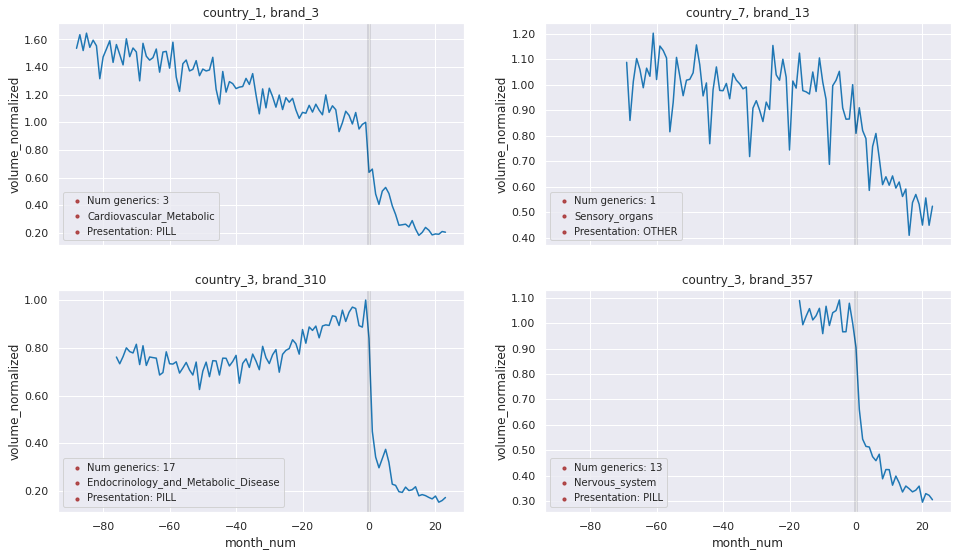

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 9), sharex=True)
products = [
  ("country_1", "brand_3"), ("country_7", "brand_13"), 
  ("country_3", "brand_310"), ("country_3", "brand_357")
]
for p, ax in zip(products, fig.get_axes()):
    _  = plot_volume(cc=p[0], bb=p[1], y_col="volume_normalized", ax=ax)

## Distributions

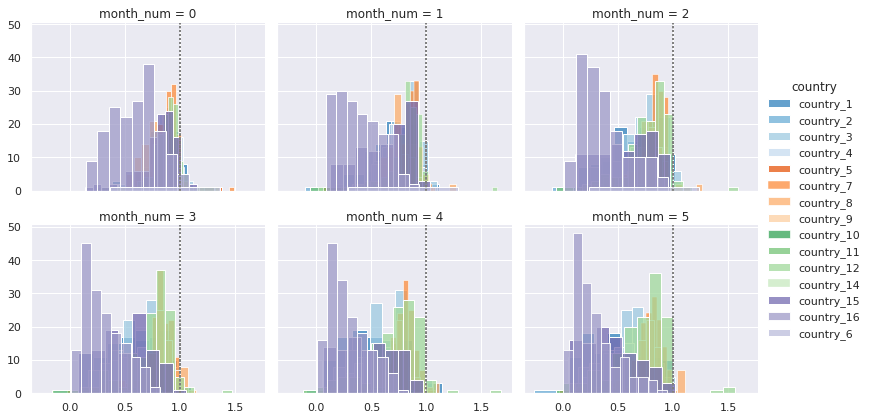

In [ ]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(
    gx_volume.query("month_num in [0, 1, 2, 3, 4, 5]"), col="month_num",
    hue="country", palette="tab20c", col_wrap=3, aspect=1.2 #height=1.5
)

# Draw a horizontal line to show the starting point
_ = grid.map(plt.axvline, x=1, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
_ = grid.map_dataframe(sns.histplot, x="volume_normalized")

# Adjust the arrangement of the plots
_ = grid.fig.tight_layout(w_pad=1)

# Add legend
_ = grid.add_legend()

# All data

In [ ]:
gx_data = (
    gx_volume
    .merge(gx_num_generics, how="left", on=["country", "brand"])
    .merge(gx_therapeutic_area, how="left", on=["brand"])
    .merge(gx_package, how="left", on=["country", "brand"])
    .merge(gx_panel_w, how="left", on=["country", "brand"])
)
print(gx_data.shape)
gx_data.head()

(94954, 13)


,country,brand,volume,month_num,month_name,volume_normalized,num_generics,therapeutic_area,presentation,channel_rate_A,channel_rate_B,channel_rate_C,channel_rate_D
0,country_1,brand_3,18509088.6,-88,Jul,1.535224,3,Cardiovascular_Metabolic,PILL,0,1.189704,0.0,98.810296
1,country_1,brand_3,19697508.0,-87,Aug,1.633796,3,Cardiovascular_Metabolic,PILL,0,1.189704,0.0,98.810296
2,country_1,brand_3,18315721.8,-86,Sep,1.519185,3,Cardiovascular_Metabolic,PILL,0,1.189704,0.0,98.810296
3,country_1,brand_3,19831199.4,-85,Oct,1.644885,3,Cardiovascular_Metabolic,PILL,0,1.189704,0.0,98.810296
4,country_1,brand_3,18593281.8,-84,Nov,1.542207,3,Cardiovascular_Metabolic,PILL,0,1.189704,0.0,98.810296


In [ ]:
# # Features
# gx_data["month_min"] = groups["month_num"].transform(min)
# gx_data["total_growth"] = groups["volume"].transform(
#     lambda x: x.div(x.iat[0], x.iat[-1]).subtract(1) )
# gx_data.head()

# Model evaluation

## Accuracy metric

To compute the prediction error we will evaluate the difference between the predicted values and the actual volume in four different ways weighted as follows:

1. Absolute __monthly__ error of all 24 months (50%)
2. Absolute __accumulated__ error of months 0 to 5 (30%)
3. Absolute __accumulated__ error of months 6 to 11 (10%)
4. Absolute __accumulated__ error of months 12 to 23 (10%)

All the four items will be normalized by the average monthly volume of the last 12 months before the generic entry in order to take into account the magnitude of the brand.

## Confidence intervals

Given the prediction intervals $(L_j, U_j)$ for a particular example we will measure 2 things with the following weights:

1. Whether the actual values fall inside the intervals (15%):
$$L_{j,i}\le Y^{act}_{j,i} \le U_{j,i}$$
2. How wide are the predictions intervals. Wider prediction intervals will have higher penalization (85%).
$$|U_{j, i} - L_{j, i}|$$

For business reasons, the confidence error for the first 6 months will be weighted more than the rest of the months (60% and 40% respectively). The error will be also normalized by the average monthly volume of the brand in the 12 months prior to the generic entry.